In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2.ximgproc as xip  # per thinning
from sklearn.cluster import KMeans
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from skimage.util import invert

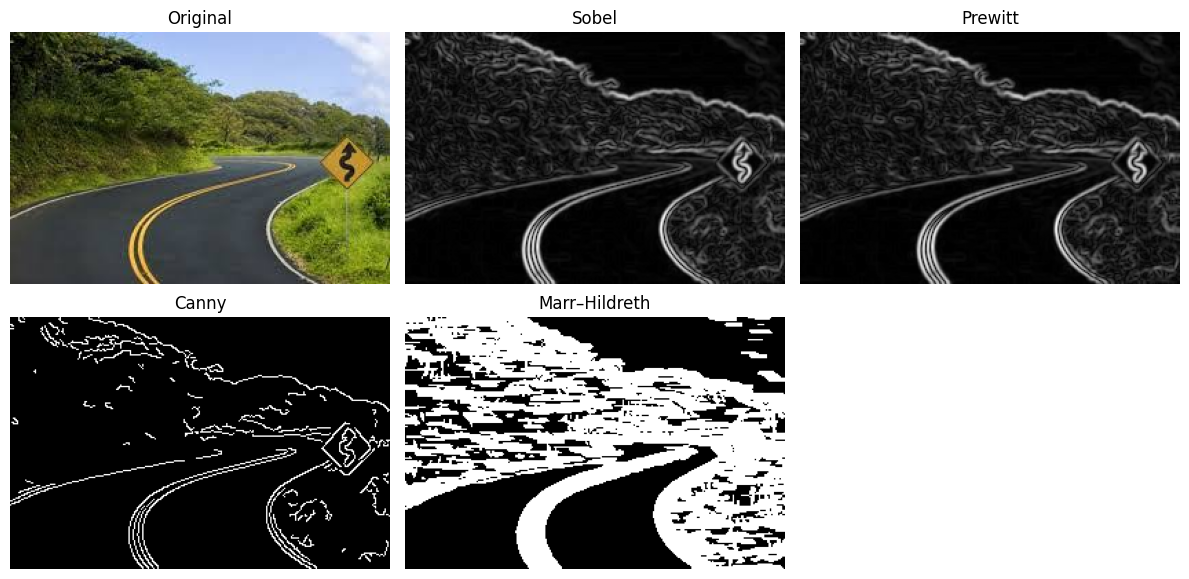

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import prewitt, sobel, laplace
from scipy.ndimage import gaussian_laplace

def marr_hildreth(img_gray, sigma=2.0, thresh=0.03):
    """
    Marr–Hildreth: LoG (Laplacian of Gaussian) + zero-crossing threshold.
    """
    # 1) aplicar Gaussià + Laplacian
    log = gaussian_laplace(img_gray, sigma=sigma)
    # 2) zero-crossings
    zc = np.zeros_like(log, dtype=bool)
    # per cada píxel, comprova canvi de signe amb veïns 4-connexió
    for dy, dx in [(-1,0),(1,0),(0,-1),(0,1)]:
        zc |= (log * np.roll(log, shift=(dy,dx), axis=(0,1)) < 0)
    # 3) umbralitzar per magnitud
    return (np.abs(log) > thresh).astype(np.uint8)

def compare_edges(image_path):
    # 1) llegir i convertir a gris
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blur = cv2.GaussianBlur(img, (5,5), 1)
    imb = cv2.imread(image_path)
    imb = cv2.cvtColor(imb, cv2.COLOR_BGR2RGB)

    # 2) Sobel (magnitud)
    sob = sobel(blur)
    # 3) Prewitt (magnitud)
    pre = prewitt(blur)
    # 4) Canny
    can = cv2.Canny(blur,100, 150)
    # 5) Marr–Hildreth
    mh = marr_hildreth(blur, sigma=2.0, thresh=0.05)

    # 6) Mostrar tots en un grid
    titles = ['Original', 'Sobel', 'Prewitt', 'Canny', 'Marr–Hildreth']
    imgs   = [imb, sob, pre, can, mh]

    plt.figure(figsize=(12,6))
    for i, (t, im) in enumerate(zip(titles, imgs), 1):
        plt.subplot(2,3,i)
        plt.imshow(im, cmap='gray')
        plt.title(t)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Prova amb qualsevol imatge local:
    compare_edges('foto17.jfif')


255


(np.float64(-0.5), np.float64(424.5), np.float64(639.5), np.float64(-0.5))

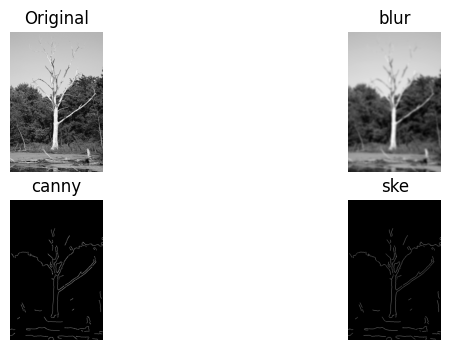

In [ ]:
imb = cv2.imread('29426.jpg')
imb = cv2.cvtColor(imb, cv2.COLOR_BGR2RGB)
img = cv2.imread('29426.jpg', cv2.IMREAD_GRAYSCALE)
blur = cv2.GaussianBlur(img, (21,21), 0)

plt.figure(figsize=(8,4))
plt.subplot(2,2,1)
plt.imshow(img, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(blur, cmap='gray'); plt.title('blur'); plt.axis('off')



edges = cv2.Canny(blur,50, 80)

print(np.max(edges))

plt.subplot(2,2,3)
plt.imshow(edges , cmap='gray'); plt.title('canny'); plt.axis('off')


binary = edges > 0            # máscara booleana
skeleton_bool = skeletonize(binary) #thinning

plt.subplot(2,2,4)
plt.imshow(skeleton_bool, cmap='gray'); plt.title('ske'); plt.axis('off')



In [ ]:
total_pixels = skeleton_bool.sum()              # total de píxels de esquelet
num_regions  = len(regionprops(label(skeleton_bool, connectivity=2)))

#Condició per aplicar filtrat
if total_pixels > 10000 or num_regions > 200:
    lbl   = label(skeleton_bool, connectivity=2)
    props = regionprops(lbl)
    clean = np.zeros_like(skeleton_bool)
    for region in props:
        if region.area >= 00:
            clean[lbl == region.label] = True
    skeleton = clean.astype(np.uint8) * 255
else:
    # si no hi ha tant soroll, ens quedem directament amb el esquelet
    skeleton = skeleton_bool.astype(np.uint8) * 255

#Extreure punts
pts = np.argwhere(skeleton > 0)

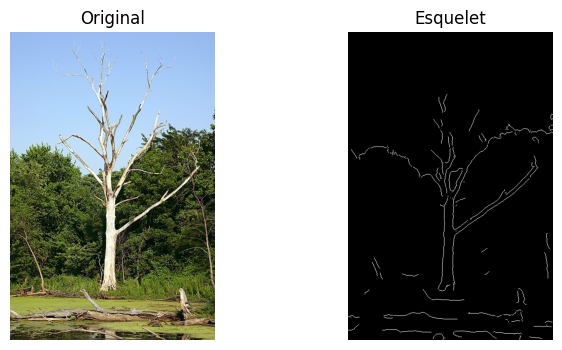

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(imb); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(skeleton, cmap='gray'); plt.title('Esquelet'); plt.axis('off')
plt.show()

In [ ]:
#Funció calcul curvatura
def compute_local_curvature(pts, window):
    curv = []
    for i in range(window, len(pts)-window):
        p1, p2, p3 = pts[i-window], pts[i], pts[i+window]
        v1, v2 = p2-p1, p3-p2
        n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
        if n1==0 or n2==0:
            continue
        u1, u2 = v1/n1, v2/n2
        angle = np.arccos(np.clip(np.dot(u1,u2), -1,1))
        k = angle / ((n1+n2)/2)
        curv.append(k)
    return np.array(curv)

curvatures = compute_local_curvature(pts, window=3) #fer mitjes altres windows

In [ ]:
#Mitjana diferentes windows
windows = [3, 5, 7]
max_w = max(windows)
common_len = len(pts) - 2*max_w

aligned = []
for w in windows:
    c = compute_local_curvature(pts, window=w)
    start = max_w - w
    aligned.append(c[start : start + common_len])

curvs_trim = np.array(aligned)         # ara shape = (3, common_len)
curvatures = curvs_trim.mean(axis=0)   # mitjana per columna


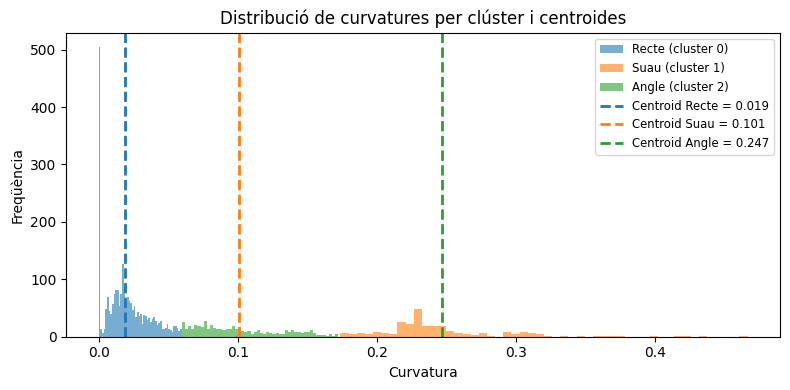

In [ ]:
# 1. Comprovem si hi ha valors de corbatura abans de fer clustering
if curvatures.size == 0:
    straight = 0
    soft = 0
    corner = 0
else:
    # 2. Clustering en 3 grups
    curv_reshaped = curvatures.reshape(-1, 1)
    kmeans = KMeans(n_clusters=3, random_state=0).fit(curv_reshaped)
    labels = kmeans.labels_
    centers = np.sort(kmeans.cluster_centers_.flatten())

    idx_recte = np.argmin(centers)
    idx_angle = np.argmax(centers)
    idx_suau  = [i for i in range(3) if i not in (idx_recte, idx_angle)][0]

    c_suau = centers[idx_suau]
    c_angle = centers[idx_angle]
    alpha =0.8
    threshold = c_angle - alpha * (c_angle - c_suau)

    # 3. Ara reconstruïm les quantitats:
    #    - Comptem com a rectangles tots els que estiguin al grup idx_recte.
    #    - Comptem com a corner només els del grup idx_angle que superin el llindar.
    #    - La resta (labels == idx_suau, més els d’idx_angle per sota del llindar) els considerem suau.
    is_recte = labels == idx_recte
    is_angle = labels == idx_angle
    # Quins d’aquests angle majors passen el llindar?
    is_angle_extrem = np.logical_and(is_angle, curvatures > threshold)

    #  ——— Visualització K-means ———
    plt.figure(figsize=(8,4))
    bins = 50
    colors = ['C0', 'C1', 'C2']
    names  = ['Recte', 'Suau', 'Angle']

    # Histograma per clúster
    for i, name in enumerate(names):
        mask = labels == i
        plt.hist(curvatures[mask], bins=bins, alpha=0.6,
                label=f'{name} (cluster {i})', color=colors[i])

    # Línies verticals pels centroides
    for i, c in enumerate(centers):
        plt.axvline(c, linestyle='--', linewidth=2,
                    label=f'Centroid {names[i]} = {c:.3f}',
                    color=colors[i])

    plt.xlabel('Curvatura')
    plt.ylabel('Freqüència')
    plt.title('Distribució de curvatures per clúster i centroides')
    plt.legend(fontsize='small', loc='upper right')
    plt.tight_layout()
    plt.show()

    straight = np.sum(is_recte)
    corner = np.sum(is_angle_extrem)
    # Tot el que quedi fora de recte i corner queda a suau
    soft = curvatures.size - straight - corner

# 4. Càlcul del total ponderat (igual que abans)
total = straight * 0.12 + soft + corner


In [ ]:
#asignació puntuació
if total > 0:
    score = (soft / total) * 10

else:
    score = 0.0

print(f"Centres de clusters: {centers}")
print(f"Counts: straight={straight}, soft={soft}, corner={corner}")
print(f"Puntuació de curvatura (0–10): {score:.2f}")

Centres de clusters: [0.01893762 0.10054773 0.24698035]
Counts: straight=2400, soft=683, corner=117
Puntuació de curvatura (0–10): 6.28
